# GPU: CuPy, Numba-GPU, PyCUDA

```
conda install cupy cudatoolkit
```

```
export CFLAGS=-fpermissive
pip install --no-cache-dir pycuda     # I have more luck with this one in pip
```

_(and numpy, matplotlib, numba from before)_

If you can get better memory efficiency using rowwise code (e.g. compiled for loops), why would you ever write columnar code (e.g. Numpy)?

**Answer:** vectorization!

Vectorization is a vertical scaling technique that uses a single CPU core or a GPU more effectively. You can compute N operations at the same time _if they are all the same operation._

<center><img src="img/vectorization-example.png" width="50%"></center>

If you don't fully utilize all cores, that's okay; someone else's work can fill the gaps.

If you don't fully utilize the core's vector unit, no one else can use them.

A GPU is a computational device designed around vector units.

Like parallel processing, this is another computing detail that is visible to you as a data analyst.

Rowwise code like

In [2]:
! pip install numba

In [3]:
import numba
@numba.jit
def run_numba_loop(height, width, maxiterations, c, fractal):
    for h in range(height):
        for w in range(width):
            z = c[h, w]
            for i in range(maxiterations):
                z = z**2 + c[h, w]
                if abs(z) > 2:
                    fractal[h, w] = i
                    break
    return fractal

/var/folders/qt/rxjvm_j566v9qn7g754s1v9hzb3p7f/T/ipykernel_28676/2476333802.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit


does not use vector units effectively because each array element may be in a different stage of processing— some may have diverged before others.

Columnar code like

In [6]:
import numpy
import time

def prepare(height, width):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numpy.zeros(c.shape, dtype=numpy.int32)
    return c, fractal

def run(c, fractal, maxiterations=20):
    fractal *= 0                  # set fractal to maxiterations without replacing it
    fractal += maxiterations
    z = c
    for i in range(maxiterations):
        z = z**2 + c
        diverge = z.real**2 + z.imag**2 > 2**2
        divnow = diverge & (fractal == maxiterations)
        fractal[divnow] = i
        z[diverge] = 2
    return fractal

can use vector units effectively because it's always applying the <b>S</b>ame <b>I</b>nstruction on <b>M</b>ultiple <b>D</b>ata (SIMD).

All we need is a librrary to implement the Numpy functions on a GPU.

In [ ]:
import cupy

In [7]:
c, fractal = prepare(4000, 6000)

# c = cupy.array(c)
# fractal = cupy.array(fractal)
#
# starttime = time.time()
fractal = run(c, fractal)
# time.time() - starttime

In [ ]:
c, fractal = prepare(4000, 6000)

starttime = time.time()
fractal = run(c, fractal)
time.time() - starttime

Exactly the same code: first with CuPy on the GPU (2.8 sec), then with Numpy on the CPU (7.5 sec).

If you're wondering why I'm working on a reduced problem (4× smaller than previous sessions), it's because I couldn't fit the full one in my GPU's memory!

(There's always a catch!)

Also, CuPy's adherence to the Numpy API isn't perfect: I had to write

```python
z.real**2 + z.imag**2
```

instead of

```python
numpy.absolute(z)
```

because the `absolute` function wasn't supported. This is the error you'd see:

In [ ]:
try:
    numpy.absolute(cupy.array([1.1, 2.2, 3.3]))
except ValueError as err:
    print(err)

Nevertheless, we can expect CuPy to become more complete as people use it and report missing features.

**GPU method #2:** Use Numba! (You have to install a "cudatoolkit" library with it.)

In [ ]:
import numba.cuda
import math

@numba.cuda.jit
def as_cuda(c, fractal, maxiterations):
    x, y = numba.cuda.grid(2)     # 2 dimensional CUDA grid
    z = c[x, y]
    fractal[x, y] = 20
    for i in range(maxiterations):
        z = z**2 + c[x, y]
        if abs(z) > 2:
            fractal[x, y] = i
            break                 # not optimal: threads that leave the loop still have to wait

def run_numba(height, width, maxiterations=20):
    y, x = numpy.ogrid[-1:0:height*1j, -1.5:0:width*1j]
    c = x + y*1j
    fractal = numba.cuda.device_array(c.shape, dtype=numpy.int32)
    as_cuda[(math.ceil(height / 32), math.ceil(width / 32)), (32, 32)](c, fractal, maxiterations)
    return fractal

In [ ]:
starttime = time.time()
fractal = run_numba(4000, 6000)
time.time() - starttime

On the same sized problem,

   * Numpy on the CPU: 7.5 sec
   * CuPy on the GPU: 2.8 sec
   * Numba on the GPU: 0.3 sec

And Numba doesn't suffer from the memory issue because it doesn't make as many intermediate copies.

In [ ]:
starttime = time.time()
fractal = run_numba(8000, 12000)    # full-sized problem
time.time() - starttime

That full-sized problem used to take us half a minute in Numpy, and (projected) 15 minutes in pure Python. For sanity's sake, we verify that it is, indeed, drawing our fractal.

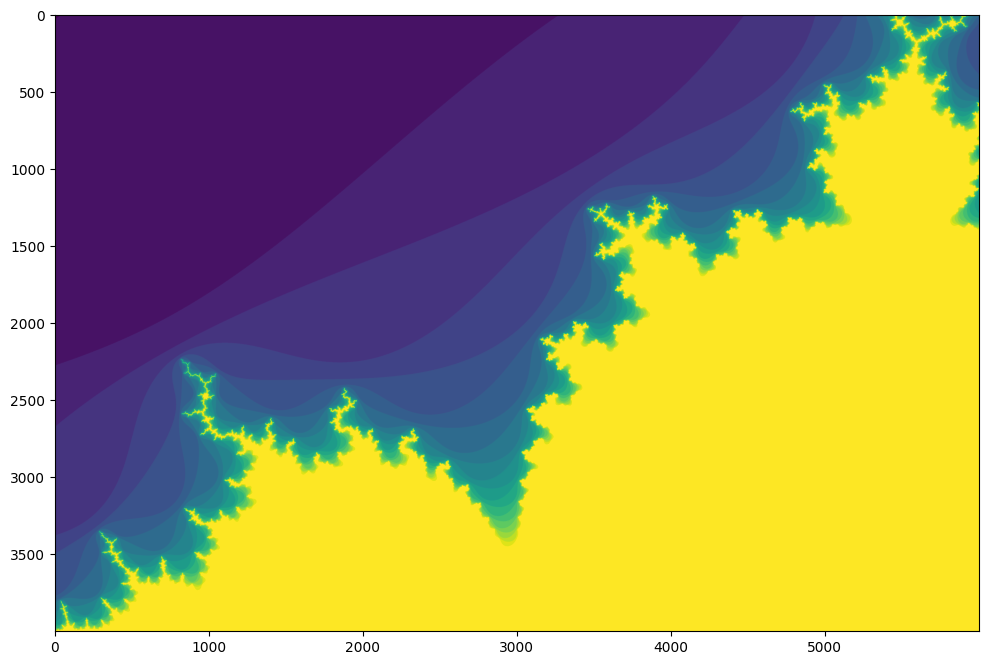

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(fractal)
# ax.imshow(fractal[-2000:, :3000])

Each library has its own special niche:

   * **CuPy:** for directly running Numpy on GPUs, no questions asked
   * **Numba:** for running (a limited subset of) Python code directly on the GPU